In [1]:
import TidalPy

# TidalPy.clear_cache()
import numpy as np
import matplotlib.pyplot as plt
from TidalPy.utilities.spherical_helper import calculate_voxel_volumes, calculate_mass_gravity_arrays
from TidalPy.utilities.conversions import days2rads, rads2days, orbital_motion2semi_a

N = 40

orbital_frequency = days2rads(6.0)
spin_frequency = days2rads(3.0)
host_mass = 2e29
planet_mass = 3.7e24
planet_radius = 5.86e6
semi_major_axis = orbital_motion2semi_a(orbital_frequency, host_mass, planet_mass)
eccentricity = 0.1
obliquity = np.radians(45.)

planet_bulk_density = planet_mass / ((4. / 3.) * np.pi * planet_radius**3)

radius_array = np.linspace(0.1, planet_radius, N)
IC_radius = 0.25 * planet_radius
OC_radius = 0.4 * planet_radius

IC_index = radius_array <= IC_radius
OC_index = np.logical_and(radius_array > IC_radius, radius_array <= OC_radius)
mantle_index = radius_array > OC_radius

viscosity_array = np.empty_like(radius_array)
viscosity_array[IC_index] = 1.0e24
viscosity_array[OC_index] = 1.0e12
viscosity_array[mantle_index] = 1.0e22

shear_array = np.empty_like(radius_array)
shear_array[IC_index] = 1.0e11
shear_array[OC_index] = 0.
shear_array[mantle_index] = 5.0e10

bulk_array = np.empty_like(radius_array)
bulk_array[IC_index] = 1.0e12
bulk_array[OC_index] = 1.0e11
bulk_array[mantle_index] = 5.0e10

density_array = np.empty_like(radius_array)
density_array[IC_index] = 10000
density_array[OC_index] = 8000
density_array[mantle_index] = 3500

volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)
longitude_array = np.radians(np.linspace(0., 360., N-1))
colatitude_array = np.radians(np.linspace(0.1, 179.9, N-2))
voxel_volumes = calculate_voxel_volumes(radius_array, longitude_array, colatitude_array)

time_domain = np.linspace(0., 86400. * rads2days(orbital_frequency), N+1)
longitude_matrix, colatitude_matrix, time_matrix = np.meshgrid(longitude_array, colatitude_array, time_domain, indexing='ij')

from TidalPy.rheology.complex_compliance.compliance_models import andrade as complex_compliance_function

is_solid_by_layer = (True, False, True)
is_static_by_layer = (False, True, False)
indices_by_layer = (IC_index, OC_index, mantle_index)

from TidalPy.tides.modes.multilayer_modes import collapse_multilayer_modes

Finished first go
Working on TimeIt
10.8 s ± 802 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


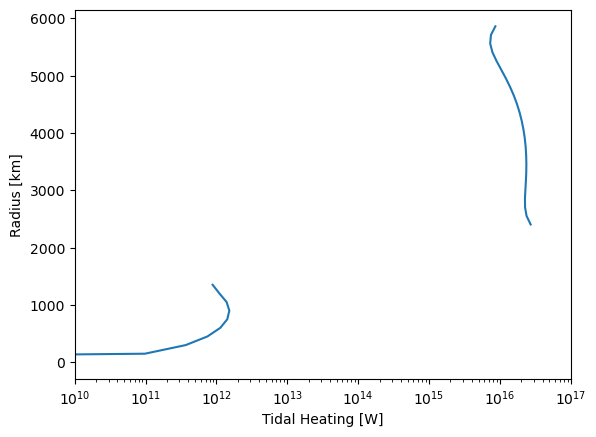

In [6]:
# SciPy Integrator (N=40)
# Times:
# v0.5.0a - 17.5s, 19.1s
# 15.7s
# 15s, 12.8s, 12.1s
# 10.5s, 11.3s, 10.8s

out = collapse_multilayer_modes(orbital_frequency, spin_frequency, semi_major_axis, eccentricity, host_mass, radius_array, shear_array, bulk_array, viscosity_array, density_array, gravity_array,longitude_matrix, colatitude_matrix, time_matrix, voxel_volumes,complex_compliance_function,is_solid_by_layer, is_static_by_layer, indices_by_layer,obliquity, use_general_obliquity=True,surface_boundary_conditions=None, solve_load_numbers=False,complex_compliance_input=None, force_mode_calculation=False,order_l=2,use_modes=True, use_static_potential=False, use_simple_potential=False,orbit_average_results=True,use_kamata=False,integrator='scipy', integration_method='RK45',integration_rtol=1.0e-9, integration_atol=1.0e-10,verbose=False, nondimensionalize=True, planet_bulk_density=planet_bulk_density, incompressible=False)
print('Finished first go')

fig, ax = plt.subplots()
ax.plot(np.sum(out[0], axis=(1,2)), radius_array/1000)
ax.set(xscale='log', xlabel='Tidal Heating [W]', ylabel='Radius [km]', xlim=(1e10, 1e17))

print('Working on TimeIt')
%timeit collapse_multilayer_modes(orbital_frequency, spin_frequency, semi_major_axis, eccentricity, host_mass, radius_array, shear_array, bulk_array, viscosity_array, density_array, gravity_array,longitude_matrix, colatitude_matrix, time_matrix, voxel_volumes,complex_compliance_function,is_solid_by_layer, is_static_by_layer, indices_by_layer,obliquity, use_general_obliquity=True,surface_boundary_conditions=None, solve_load_numbers=False,complex_compliance_input=None, force_mode_calculation=False,order_l=2,use_modes=True, use_static_potential=False, use_simple_potential=False,orbit_average_results=True,use_kamata=False,integrator='scipy', integration_method='RK45',integration_rtol=1.0e-9, integration_atol=1.0e-10,verbose=False, nondimensionalize=True, planet_bulk_density=planet_bulk_density,incompressible=False)

Finished first go
Working on TimeIt
9.07 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


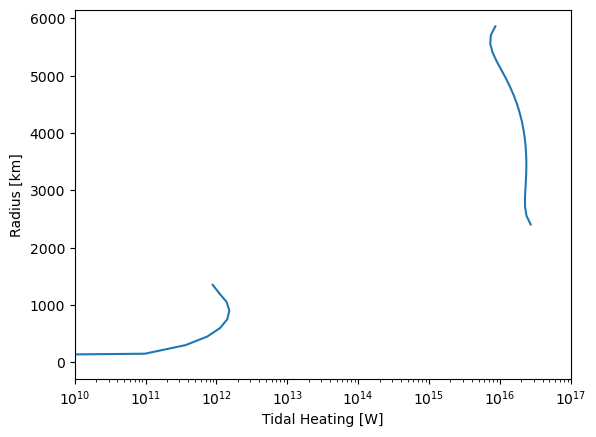

In [7]:
# Numba Integrator (N=40)
# Times:
# v0.5.0a - 14.7s. 15.3s
# 13.9s
# 13.1s, 11.9s, 10.5s
# 9.3s, 13s, 9.07s

out = collapse_multilayer_modes(orbital_frequency, spin_frequency, semi_major_axis, eccentricity, host_mass, radius_array, shear_array, bulk_array, viscosity_array, density_array, gravity_array,longitude_matrix, colatitude_matrix, time_matrix, voxel_volumes,complex_compliance_function,is_solid_by_layer, is_static_by_layer, indices_by_layer,obliquity, use_general_obliquity=True,surface_boundary_conditions=None, solve_load_numbers=False,complex_compliance_input=None, force_mode_calculation=False,order_l=2,use_modes=True, use_static_potential=False, use_simple_potential=False,orbit_average_results=True,use_kamata=False,integrator='numba', integration_method='RK45',integration_rtol=1.0e-9, integration_atol=1.0e-10,verbose=False, nondimensionalize=True, planet_bulk_density=planet_bulk_density, incompressible=False)
print('Finished first go')

fig, ax = plt.subplots()
ax.plot(np.sum(out[0], axis=(1,2)), radius_array/1000)
ax.set(xscale='log', xlabel='Tidal Heating [W]', ylabel='Radius [km]', xlim=(1e10, 1e17))

print('Working on TimeIt')
%timeit collapse_multilayer_modes(orbital_frequency, spin_frequency, semi_major_axis, eccentricity, host_mass, radius_array, shear_array, bulk_array, viscosity_array, density_array, gravity_array,longitude_matrix, colatitude_matrix, time_matrix, voxel_volumes,complex_compliance_function,is_solid_by_layer, is_static_by_layer, indices_by_layer,obliquity, use_general_obliquity=True,surface_boundary_conditions=None, solve_load_numbers=False,complex_compliance_input=None, force_mode_calculation=False,order_l=2,use_modes=True, use_static_potential=False, use_simple_potential=False,orbit_average_results=True,use_kamata=False,integrator='numba', integration_method='RK45',integration_rtol=1.0e-9, integration_atol=1.0e-10,verbose=False, nondimensionalize=True, planet_bulk_density=planet_bulk_density,incompressible=False)